In [12]:
import os
import numpy as np
import torch
import torch.nn as nn
import tqdm
import torch.nn.functional as F
from torchvision.transforms.functional import to_pil_image
import torchvision.models as models
import torchvision.transforms as transforms
import torch.utils.data as data
from torch.utils.data import random_split
import torchvision
from torch.autograd import Variable
import matplotlib.pyplot as plt
from model import *
from dataloader import TTDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.metrics import accuracy_score
import pickle
import cv2
from PIL import Image,ImageDraw
from copy import deepcopy

data_path = '/media/E/dataset/dataset'    # define UCF-101 RGB data path
action_name_path = './UCF101actions.pkl'#/content/content
save_model_path = 'checkpoints'#os.path.join("","checkpoints")
is_training = True
epoch_num = 7 # checkpoint number u want to load

# EncoderCNN architecture
img_x, img_y = int(1080*0.3), int(1920*0.3)  # resize video 2d frame size
# [128,320]

dropout_p = 0.0          # dropout probability

k = 3             # number of target category
epochs = 50        # training epochs
batch_size = 20
learning_rate = 1e-4
log_interval = 2   # interval for displaying training info


# Detect devices
use_cuda = torch.cuda.is_available()                   # check if GPU exists
device = torch.device("cuda" if use_cuda else "cpu")   # use CPU or GPU


transform = transforms.Compose([transforms.Resize([img_x, img_y]),
                                transforms.Grayscale()])#,transforms.Normalize(mean=(0.5,), std=(0.5,)
                                # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

# transform = transforms.Compose([transforms.ToTensor()])
def collate_fn(batch):
    batch = list(filter(lambda x: x is not None, batch))
    if len(batch)==0:
       return None
    return torch.utils.data.dataloader.default_collate(batch)



dataset = TTDataset(data_path+"/test",transform=transform,size=(img_x,img_y),n_frames=2)
model = TTNet(dropout_p=0.5,in_ch=1,device=device).to(device)
test_loader = torch.utils.data.DataLoader(dataset,num_workers=2,collate_fn = collate_fn,batch_size=batch_size, shuffle=True)

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

model.load_state_dict(torch.load('checkpoints/model_45.pth',map_location=device))



# validation(log_interval, model, device, val_loader, epoch)
def test(model, device, test_loader):
    # set model as testing mode
    model.eval()
    batch_size = 10
    test_loss = 0
    with torch.no_grad():
        for data in test_loader:
            # distribute data to device
            if data is None:
              continue
            X, y = data[0],data[1]
            X, y = X.to(device), y.to(device)
            output = model(X)
            loss = F.mse_loss(output, y)
            test_loss += loss.item()                 # sum up batch loss
            images_array = X.cpu().data.squeeze()
            predictions = y.cpu().data.squeeze()
            centers = predictions.view(batch_size, -1, 2)
            images = [None]*batch_size
            for i in range(batch_size):
                images[i] = Image.fromarray( images_array[i].numpy().astype('uint8').squeeze(), mode='L')
            images[0]
            for i in range(batch_size):
                image = images[i]
                draw = ImageDraw.Draw(image)
                for j in range(centers.shape[1]):
                    center_x, center_y = centers[i, j]
                    radius = 10
                    draw.ellipse((center_x-radius, center_y-radius, center_x+radius, center_y+radius), outline='red', fill='white', width=3)
                image.save(f'image_{i}.jpg')

            kk
                    
    test_loss /= len(test_loader.dataset)


    # show information
    print('\nTest set ({:d} samples): Average loss: {:.4f}\n'.format(len(test_loader), test_loss))

    return test_loss

test(model,device,test_loader)




RuntimeError: shape '[10, -1, 2]' is invalid for input of size 28

[283.53742922 277.55800849 245.69038545 266.24880226 255.31015897
 194.82739003 164.94870155 227.73101318 169.65765189 148.62429225
 157.06145198 147.97728386  72.66512413  59.83912919  46.01534598
  36.0583998    9.24907363  22.74005233  25.52981748  63.28399254
  35.18395783   8.75202713  19.85767878  12.57552707  10.63156117
  26.97163886  19.34681069  17.72618651  67.70034843   5.15951442
   9.55789195  15.13813426  10.82904287  20.87758772   9.49418146
   7.72466041  13.16531978  11.88412507  11.80044183  76.84519273
  44.46160782  10.94775476  21.16714871  18.23165968  11.65647713
  10.9837387   11.95064787  36.31133969  18.33500857   9.57681328
   6.88143145  26.17462945  28.29547311   8.93145858  22.80188201
  10.32469597   9.09743678  11.20692236  37.46282938   8.95784619
  13.2992492    7.4987776   11.06474235   6.26509674  10.20067339
   6.93249597   7.50304453  13.69596071  13.24424951  34.84922147
   6.89942597  17.65869141  14.96259289  13.87830143  13.68259592
  13.64939

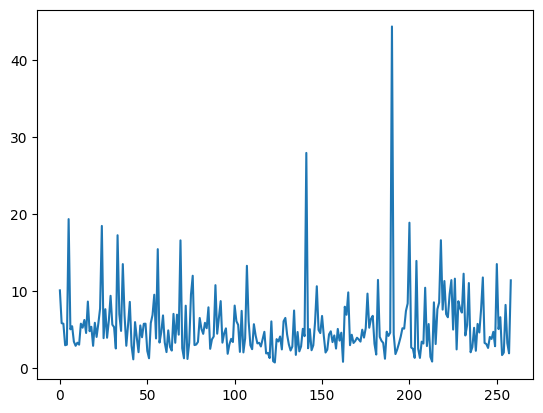

In [11]:
import numpy as np
from matplotlib import pyplot as plt
h = np.load('checkpoints/model_epoch_train_loss.npy')
print(h[0]/287)
plt.plot((h/287)[49])
plt.show()

(50, 1)


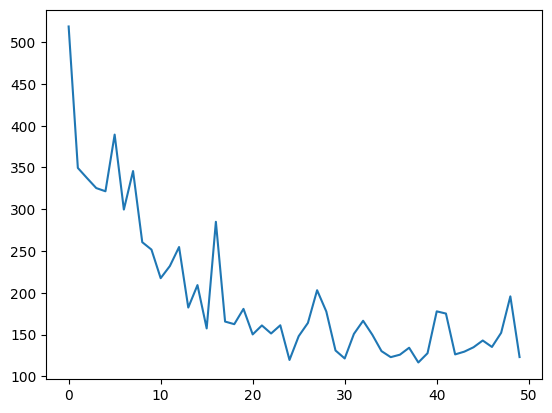

In [14]:
h = np.load('checkpoints/model_epoch_test_loss.npy').reshape((50,1))
print(h.shape)
plt.plot(np.sum(h,axis=1))
plt.show()

In [46]:
import json
import os


def preprocess_annotations(root_dir):

    # {"file_name", "event"}

    events_markup_paths = [os.path.join(root_dir, dir,"events_markup.json")  for dir in os.listdir(root_dir)]
    ball_markups_paths = [os.path.join(root_dir, dir,"ball_markup.json")  for dir in os.listdir(root_dir)]
    # open all the files
    all_markups = []
    for i,(events_markup_path,ball_markups_path) in enumerate(zip(events_markup_paths,ball_markups_paths)):
        fp_events_markup = open(events_markup_path, "r")
        fp_ball_markup = open(ball_markups_path, "r")

        data_dir = events_markup_path.split('/')[:-1]
        events_data = json.load(fp_events_markup)
        ball_data = json.load(fp_ball_markup)

        all_markups.extend(
            [os.path.join('/',*data_dir, "images/img_"+key.zfill(6)+".jpg"), [value['x'],value['y']]]
            for key, value in ball_data.items()
        )
            # create file name
    return all_markups

paths = preprocess_annotations('/media/E/dataset/dataset'+'/train')

with open('path.json','w') as f:
    json.dump(paths,f)


In [9]:
for i,j in enumerate(zip([1,2,3],[2,3,4])):
    print(i,j)

0 (1, 2)
1 (2, 3)
2 (3, 4)


In [49]:
import torchvision.transforms as transforms

help(transforms.Resize)

Help on class Resize in module torchvision.transforms.transforms:

class Resize(torch.nn.modules.module.Module)
 |  Resize(size, interpolation=<InterpolationMode.BILINEAR: 'bilinear'>, max_size=None, antialias=None)
 |  
 |  Resize the input image to the given size.
 |  If the image is torch Tensor, it is expected
 |  to have [..., H, W] shape, where ... means an arbitrary number of leading dimensions
 |  
 |  .. warning::
 |      The output image might be different depending on its type: when downsampling, the interpolation of PIL images
 |      and tensors is slightly different, because PIL applies antialiasing. This may lead to significant differences
 |      in the performance of a network. Therefore, it is preferable to train and serve a model with the same input
 |      types. See also below the ``antialias`` parameter, which can help making the output of PIL images and tensors
 |      closer.
 |  
 |  Args:
 |      size (sequence or int): Desired output size. If size is a sequen

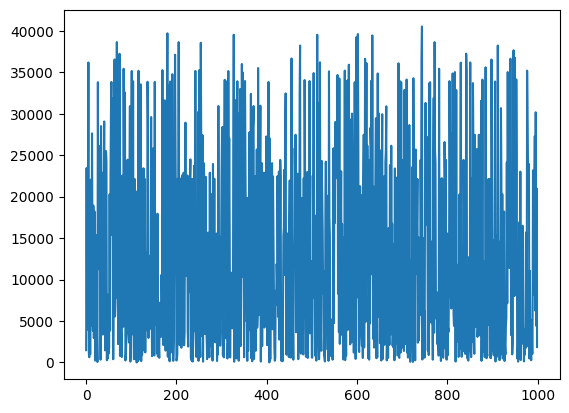

In [53]:
from matplotlib import pyplot as plt
import numpy as np
plt.plot(np.load('model_localization_epoch_train_loss.npy'))
plt.show()

In [57]:
import torch
from PIL import Image

# Load the saved tensor from the .pt file
saved_tensor = torch.load("heatmap.pt")

# Convert the tensor to a PIL Image
img = saved_tensor.detach().numpy()*255
img_ = img.reshape((320,128))
pil_image = Image.fromarray(img_)

# Save the PIL Image as a PNG file
pil_image.save("saved_image.png")


ValueError: cannot reshape array of size 448 into shape (320,128)

In [ ]:
import cv2
import numpy as np

# Load the heatmap image
heatmap = cv2.imread('heatmap.png', cv2.IMREAD_GRAYSCALE)

# Apply a binary threshold to the heatmap
threshold_value = 127
max_value = 255
ret, thresholded_heatmap = cv2.threshold(heatmap, threshold_value, max_value, cv2.THRESH_BINARY)

# Save the thresholded heatmap
cv2.imwrite('thresholded_heatmap.png', thresholded_heatmap)


In [4]:
def get_crop_coords(coord, width, height, crop_size):
    """
    Calculate the crop coordinates around a single coordinate.

    Args:
        coord (tuple): Tuple of (x, y) coordinates of the center of the crop region.
        width (int): Width of the image in pixels.
        height (int): Height of the image in pixels.
        crop_size (int): Size of the square crop region in pixels.

    Returns:
        tuple: Tuple of (x0, y0, x1, y1) coordinates defining the bounding box of the crop region.
    """
    # Calculate the half size of the crop region
    crop_half_width = crop_size[1] // 2
    crop_half_height = crop_size[0] // 2

    # Calculate the x and y coordinates of the upper-left corner of the crop region
    x0 = max(coord[0] - crop_half_width, 0)
    y0 = max(coord[1] - crop_half_height, 0)

    # Calculate the x and y coordinates of the lower-right corner of the crop region
    x1 = min(coord[0] + crop_half_width, width)
    y1 = min(coord[1] + crop_half_height, height)


    # Return the crop coordinates as a tuple
    return (x0, y0, x1, y1)


In [8]:
# Define the single coordinate, image width and height, and crop size
coord = (1910, 200)  # x,y coordinate of the center of the crop region
width = 1920
height = 1080

# Get the crop coordinates
crop_coords = get_crop_coords(coord, width, height, (128,320))

# Display the crop coordinates
print(crop_coords)


(1750, 136, 1920, 264)


In [10]:
from PIL import Image

def crop_image(image_path, coords, output_path):
    """
    Crop an image around a pair of coordinates and save the cropped image.

    Args:
        image_path (str): Path to the input image file.
        coords (tuple): Tuple of (x0, y0, x1, y1) coordinates defining the
            bounding box of the crop region.
        output_path (str): Path to save the cropped image file.
    """
    # Open the input image file
    with Image.open(image_path) as image:
        # Crop the image
        cropped_image = image.crop(coords)
        
        # Save the cropped image
        cropped_image.save(output_path)


In [11]:
# Define the input image path, crop coordinates, and output path
image_path = "img.jpg"
coords = get_crop_coords((500,500),1920, 1080, (128, 320))  # crop a 200x200 region starting from (100, 100)
output_path = "cropped_image.jpg"

# Crop the image and save the cropped image
crop_image(image_path, coords, output_path)
